#Симетричний прогин круглої пластинки.

$\cfrac{1}{r}\cfrac{d}{dr} \left( r\cfrac{d}{dr} \left( \cfrac{1}{r} \cfrac{d}{dr} \left( r \cfrac{dw}{dr} \right) \right) \right) = \cfrac{q}{D}$

Або

$\cfrac{d^4w}{dr^4}+\cfrac{2}{r}\cfrac{d^3w}{dr^3}-\cfrac{1}{r^2}\cfrac{d^2w}{dr^2}+\cfrac{1}{r^3}\cfrac{dw}{dr}=\cfrac{q}{D}$

1 * u_xxxx + 2/x * u_xxx - 1/(x*x) * u_xx + 1/(x*x*x)*u_x

##Кругла пластинка защемлена по контуру

Граничні умови:

$\cfrac{dw}{dr}(a)=0, $

$\cfrac{dw}{dr}(0)=0, $

$w(a)=0.$

Тоді розв'язок:

$w(r)=\cfrac{q}{64D}(a^2-r^2)^2$

Максимальний прогин в центрі пластини:

$w_{max}=\cfrac{qa^4}{64D}$

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
a = 0.4
q = 0.05
G = 2.77 * 10**4
nu = 0.3
E = 2*G*(1+nu)
h = 18*10**(-3)
D = E*h**3/(12*(1-nu**2))
print(E)
print(D)

72020.0
0.03846342857142858


In [ ]:
def w(r, D):
    bending = q/(64*D)*(a**2-r**2)**2
    bending = np.round(bending, 6)
    return bending

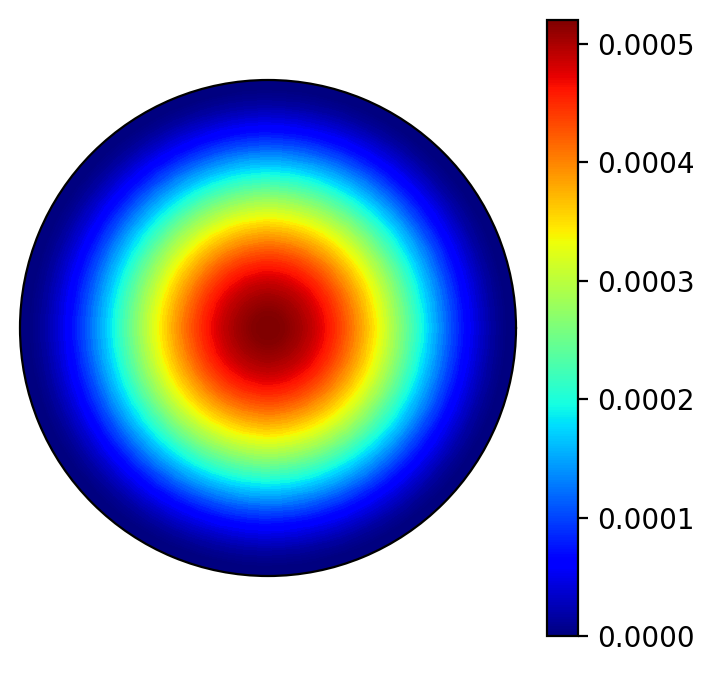

0.00052


In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = Axes3D(fig)
ax.set_title('With masked values')
rad = np.linspace(0, a, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
z = w(r, D)

plt.subplot(projection="polar")

cs = plt.pcolormesh(th, r, z, cmap='jet')

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.grid()
cbar = fig.colorbar(cs)

plt.show()

print(w(0,D))

#Розв'язок за допомогою PINN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        # def init_weights(m):
        #     if isinstance(m, nn.Linear):
        #         nn.init.xavier_normal(m.weight)
        #         m.bias.data.fill_(0.01)
        self.net = nn.Sequential(
            nn.Linear(1,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            # nn.Tanh(),
            # nn.Linear(8,8),
            # nn.Tanh(),
            # nn.Linear(8,8),

            nn.ReLU(),

            nn.Linear(8,1)

            # nn.Linear(1,64),
            # nn.Tanh(),
            # # nn.Linear(64,64),
            # # nn.Tanh(),
            # # nn.Linear(64,64),
            # # nn.Tanh(),
            # # nn.Linear(64,64),
            # # nn.Tanh(),
            # # nn.Linear(64,64),
            # # nn.Tanh(),
            # nn.Linear(64,1)



        )

        # self.apply(init_weights)
        self.double()
    def forward(self,x):
        return self.net(x)

In [ ]:
x = torch.rand(10, 1, requires_grad = True)
x

tensor([[0.5874],
        [0.6060],
        [0.2088],
        [0.2961],
        [0.3193],
        [0.8587],
        [0.1302],
        [0.0864],
        [0.9720],
        [0.8501]], requires_grad=True)

In [ ]:
x = (0 - 2)*torch.rand(10, 1, requires_grad = True) + 2 + 0.000000000001
x

tensor([[1.4346],
        [1.5956],
        [1.9418],
        [1.5332],
        [1.5190],
        [0.0476],
        [1.9731],
        [1.3300],
        [0.7703],
        [0.7593]], grad_fn=<AddBackward0>)

In [ ]:
def initial_condition():
    return torch.tensor([0])

def boundary_condition():
    return torch.tensor([0])

In [ ]:
def generate_training_data(num_points, R):
    # x = torch.rand(num_points, 1, requires_grad = True)

    x = (0 - R)*torch.rand(num_points, 1, requires_grad = True) + R + 0.001

    # x_vals = torch.linspace(0+0.0000000000001, R-0.0000000000001, num_points, requires_grad = True)
    # x = torch.stack([x_vals.double()], dim=1)

    return x

In [ ]:
tmp = torch.tensor([0.4])
tmp.view(-1,1)

tensor([[0.4000]])

In [ ]:
def generate_boundary_points(b_point):
    x_boundary = torch.tensor([b_point],  requires_grad = True)


    return x_boundary.view(-1,1)


def generate_boundary_training_data(b_point):
    x_boundary = generate_boundary_points(b_point)


    return x_boundary

In [ ]:
def pde(x, model, q, D):

    x = x.double()

    # print('*********************************************************')
    # print(x.size())
    # print(x.dtype)

    input_data = x

    # print('*********************************************************')
    # print(input_data.size())
    # print(input_data.dtype)

    u = model(input_data)
    u_x = torch.autograd.grad(u, x, grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs= torch.ones_like(u_xx), create_graph= True, retain_graph=True)[0]
    u_xxxx = torch.autograd.grad(u_xxx, x, grad_outputs= torch.ones_like(u_xxx), create_graph= True, retain_graph=True)[0]
    # print('*********************************************************')
    # print(u_x.size())
    # print(u_x.dtype)
    # print('*********************************************************')
    # print(u.size())
    # print(u.dtype)
    # print('*********************************************************')
    # print(x.size())
    # print(x.dtype)

    residual_r = torch.tensor([q/D]).double()

    eq_residual = 1 * (x*x*x) * u_xxxx + 2 * (x*x) * u_xxx - 1 * x * u_xx + 1* u_x
    return eq_residual

In [ ]:
def train_PINN(model, num_iterations, num_points, q, R, D):


    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # optimizer = optim.SGD(model.parameters(), lr=1e-3)
    # optimizer = optim.LBFGS(model.parameters())
    # breakpoint()
    for  iteration in range(num_iterations):
        optimizer.zero_grad()

        # breakpoint()

        x = generate_training_data(num_points, R)


        x_b = generate_boundary_training_data(R)

        # print(x_b)
        # breakpoint()

        x_initial = torch.tensor([0.0],  requires_grad = True)
        x_initial = x_initial.view(-1,1)
        x_initial = x_initial.double()
        u_initial_x = initial_condition()
        u_initial_x = u_initial_x.double()


        u_boundary_x = boundary_condition()

        # print(u_boundary_x)
        # breakpoint()

        residual = pde(x, model, q, D)

        # print(residual)
        # breakpoint()

        u_boundary_x = u_boundary_x.double()
        x_b = x_b.double()



        ub = model(x_b)
        ui = model(x_initial)

        # print(ub)
        # breakpoint()

        ub_x = torch.autograd.grad(ub, x_b, grad_outputs= torch.ones_like(ub), create_graph= True, retain_graph=True)[0]
        ui_x = torch.autograd.grad(ui, x_initial, grad_outputs= torch.ones_like(ui), create_graph= True, retain_graph=True)[0]

        # print(ub_x)
        # print(ui_x)


        # print('*********************************************************')
        # print(u_boundary_x.size())
        # print(u_boundary_x.dtype)
        # print('*********************************************************')
        # print(x_b.size())
        # print(x_b.dtype)
        # print('*********************************************************')

        # breakpoint()

        residual_r = torch.tensor([q/D]).double()

        # print(residual_r)

        # loss =  nn.MSELoss()(u_boundary_x, ub) + \
        #         nn.MSELoss()(u_boundary_x, ub_x) + \
        #         nn.MSELoss()(u_initial_x, ui_x) + \
        #         nn.MSELoss()(residual, torch.zeros_like(residual))

        loss =  nn.MSELoss()(u_boundary_x, ub) + \
                nn.MSELoss()(u_boundary_x, ub_x) + \
                nn.MSELoss()(u_initial_x, ui_x) + \
                nn.MSELoss()(residual,  (x*x*x)*residual_r)

        # l1_regularization, l2_regularization = torch.tensor(0.0), torch.tensor(0.0)
        # for param in model.parameters():
        #     l1_regularization += torch.norm(param, 1)**2
        #     l2_regularization += torch.norm(param, 2)**2

        # loss = loss + l1_regularization + l2_regularization

        # print(loss.dtype)


        # breakpoint()

        loss.backward()

        # breakpoint()

        optimizer.step()

        # breakpoint()

        if iteration % 100 == 0:
            print("itration", iteration, "loss", loss )

In [ ]:
a

0.4

In [ ]:
model = PINN()
num_iterations = 20000
num_points = 500
train_PINN(model, num_iterations, num_points, q, a, D)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


itration 0 loss tensor(0.0697, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 100 loss tensor(0.0464, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 200 loss tensor(0.0275, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 300 loss tensor(0.0145, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 400 loss tensor(0.0061, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 500 loss tensor(0.0015, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 600 loss tensor(0.0008, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 700 loss tensor(0.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 800 loss tensor(0.0008, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 900 loss tensor(0.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1000 loss tensor(0.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1100 loss tensor(0.0006, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1200 loss tensor(0.0006, dtype=torch.float64, grad_fn=<

In [ ]:
with torch.no_grad():
    x_vals = torch.linspace(0, a-0.001, 50)


    input_data = torch.stack([x_vals.double()], dim=1)
    solution = model(input_data)
    sol = torch.stack([x_vals, solution.flatten()], dim=1)

    print(sol)



tensor([[ 0.0000e+00,  5.1538e-04],
        [ 8.1429e-03,  5.1504e-04],
        [ 1.6286e-02,  5.1377e-04],
        [ 2.4429e-02,  5.1160e-04],
        [ 3.2571e-02,  5.0854e-04],
        [ 4.0714e-02,  5.0460e-04],
        [ 4.8857e-02,  4.9979e-04],
        [ 5.7000e-02,  4.9414e-04],
        [ 6.5143e-02,  4.8766e-04],
        [ 7.3286e-02,  4.8037e-04],
        [ 8.1429e-02,  4.7229e-04],
        [ 8.9571e-02,  4.6345e-04],
        [ 9.7714e-02,  4.5388e-04],
        [ 1.0586e-01,  4.4358e-04],
        [ 1.1400e-01,  4.3261e-04],
        [ 1.2214e-01,  4.2099e-04],
        [ 1.3029e-01,  4.0874e-04],
        [ 1.3843e-01,  3.9591e-04],
        [ 1.4657e-01,  3.8254e-04],
        [ 1.5471e-01,  3.6865e-04],
        [ 1.6286e-01,  3.5429e-04],
        [ 1.7100e-01,  3.3951e-04],
        [ 1.7914e-01,  3.2435e-04],
        [ 1.8729e-01,  3.0885e-04],
        [ 1.9543e-01,  2.9306e-04],
        [ 2.0357e-01,  2.7705e-04],
        [ 2.1171e-01,  2.6085e-04],
        [ 2.1986e-01,  2.445

In [ ]:
sol_np = sol.numpy()
np.shape(sol_np)
points = sol_np[:, 0]
points

array([0.        , 0.00814286, 0.01628571, 0.02442857, 0.03257143,
       0.04071429, 0.04885714, 0.057     , 0.06514286, 0.07328571,
       0.08142857, 0.08957142, 0.09771428, 0.10585714, 0.11399999,
       0.12214285, 0.13028571, 0.13842857, 0.14657143, 0.15471429,
       0.16285715, 0.17099999, 0.17914285, 0.18728571, 0.19542857,
       0.20357142, 0.21171428, 0.21985714, 0.228     , 0.23614284,
       0.2442857 , 0.25242856, 0.26057142, 0.26871428, 0.27685714,
       0.285     , 0.29314286, 0.30128571, 0.30942857, 0.31757143,
       0.32571429, 0.33385712, 0.34199998, 0.35014284, 0.3582857 ,
       0.36642855, 0.37457141, 0.38271427, 0.39085713, 0.39899999])

In [ ]:
pred_y = []
true_y = []
pred_y = sol_np[:, 1]
for x in points:
    true_y.append(w(x, D))

print(true_y)

[0.00052, 0.00052, 0.000518, 0.000516, 0.000513, 0.000509, 0.000505, 0.000499, 0.000493, 0.000486, 0.000478, 0.000469, 0.00046, 0.00045, 0.000439, 0.000428, 0.000415, 0.000403, 0.00039, 0.000376, 0.000362, 0.000347, 0.000332, 0.000317, 0.000301, 0.000286, 0.000269, 0.000253, 0.000237, 0.000221, 0.000204, 0.000188, 0.000172, 0.000157, 0.000141, 0.000126, 0.000111, 9.7e-05, 8.4e-05, 7.1e-05, 5.9e-05, 4.8e-05, 3.8e-05, 2.8e-05, 2e-05, 1.3e-05, 8e-06, 4e-06, 1e-06, 0.0]


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

def plot_feature(true_y, pred_y, points):

    fig_prices = go.Figure()
    fig_prices.add_trace(go.Scatter(x=points, y=true_y,
                        # fill= 'tonexty',
                        mode='lines',
                        # line_color='indigo',
                        name="Точний розв'язок"))
    fig_prices.add_trace(go.Scatter(
                        x=points,
                        y=pred_y,
                        # fill='tonexty', # fill area between trace0 and trace1
                        mode='lines',
                        # line_color='red',
                        name="Наближений розв'язок"))


    fig_prices.update_layout(yaxis_title="Значення функції")
    fig_prices.update_layout(
    xaxis=dict(
        title='Точки колокації',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі X
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    yaxis=dict(
        title='Значення функції',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі Y
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    legend=dict(
        font=dict(size=18)          # Збільшення розміру шрифту легенди
    )
)
    fig_prices.show()

    return 0

In [ ]:
plot_feature(true_y, pred_y, points)

0

In [ ]:
import pandas as pd
import numpy as np

# Об'єднання масивів в DataFrame та назви стовпців
df = pd.DataFrame({'True': true_y, 'Pred': np.round(pred_y, 6)})

# Вивід DataFrame
print(df)

        True      Pred
0   0.000520  0.000515
1   0.000520  0.000515
2   0.000518  0.000514
3   0.000516  0.000512
4   0.000513  0.000509
5   0.000509  0.000505
6   0.000505  0.000500
7   0.000499  0.000494
8   0.000493  0.000488
9   0.000486  0.000480
10  0.000478  0.000472
11  0.000469  0.000463
12  0.000460  0.000454
13  0.000450  0.000444
14  0.000439  0.000433
15  0.000428  0.000421
16  0.000415  0.000409
17  0.000403  0.000396
18  0.000390  0.000383
19  0.000376  0.000369
20  0.000362  0.000354
21  0.000347  0.000340
22  0.000332  0.000324
23  0.000317  0.000309
24  0.000301  0.000293
25  0.000286  0.000277
26  0.000269  0.000261
27  0.000253  0.000245
28  0.000237  0.000228
29  0.000221  0.000212
30  0.000204  0.000195
31  0.000188  0.000179
32  0.000172  0.000163
33  0.000157  0.000147
34  0.000141  0.000132
35  0.000126  0.000117
36  0.000111  0.000102
37  0.000097  0.000088
38  0.000084  0.000075
39  0.000071  0.000062
40  0.000059  0.000050
41  0.000048  0.000039
42  0.00003

In [ ]:
np.round(pred_y, 6)

array([ 5.15e-04,  5.15e-04,  5.14e-04,  5.12e-04,  5.09e-04,  5.05e-04,
        5.00e-04,  4.94e-04,  4.88e-04,  4.80e-04,  4.72e-04,  4.63e-04,
        4.54e-04,  4.44e-04,  4.33e-04,  4.21e-04,  4.09e-04,  3.96e-04,
        3.83e-04,  3.69e-04,  3.54e-04,  3.40e-04,  3.24e-04,  3.09e-04,
        2.93e-04,  2.77e-04,  2.61e-04,  2.45e-04,  2.28e-04,  2.12e-04,
        1.95e-04,  1.79e-04,  1.63e-04,  1.47e-04,  1.32e-04,  1.17e-04,
        1.02e-04,  8.80e-05,  7.50e-05,  6.20e-05,  5.00e-05,  3.90e-05,
        2.90e-05,  2.00e-05,  1.20e-05,  5.00e-06, -0.00e+00, -4.00e-06,
       -7.00e-06, -8.00e-06])

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error([true_y[0]], [pred_y[0]])

0.008878126739505292

In [ ]:
pred_y

array([ 5.15383374e-04,  5.15035496e-04,  5.13771484e-04,  5.11602280e-04,
        5.08540207e-04,  5.04599019e-04,  4.99793960e-04,  4.94141800e-04,
        4.87660896e-04,  4.80371240e-04,  4.72294504e-04,  4.63454092e-04,
        4.53875154e-04,  4.43584676e-04,  4.32611496e-04,  4.20986311e-04,
        4.08741772e-04,  3.95912475e-04,  3.82535005e-04,  3.68647957e-04,
        3.54291963e-04,  3.39509743e-04,  3.24346010e-04,  3.08847651e-04,
        2.93063630e-04,  2.77045026e-04,  2.60845041e-04,  2.44519005e-04,
        2.28124378e-04,  2.11720781e-04,  1.95369878e-04,  1.79135554e-04,
        1.63083789e-04,  1.47282689e-04,  1.31802482e-04,  1.16715513e-04,
        1.02096243e-04,  8.80212452e-05,  7.45692050e-05,  6.18209186e-05,
        4.98592947e-05,  3.87693943e-05,  2.86382753e-05,  1.95552395e-05,
        1.16116713e-05,  4.90108414e-06, -4.80876000e-07, -4.43642770e-06,
       -6.86565370e-06, -7.66650327e-06])

In [ ]:
len(points)

50

In [ ]:
len(pred_y)

50

In [ ]:
np.shape(z)

(100, 100)

In [ ]:
def transform_to_matrix(input_array):
    n = len(input_array)
    reshaped_matrix = np.array([np.repeat(value, n) for value in input_array])
    return reshaped_matrix

z = pred_y
result_matrix = transform_to_matrix(z)

print("Оригінальний масив:", z)
print("Масив розмірності (n, n) з векторами та повторюваними значеннями:", result_matrix)


Оригінальний масив: [ 5.15383374e-04  5.15035496e-04  5.13771484e-04  5.11602280e-04
  5.08540207e-04  5.04599019e-04  4.99793960e-04  4.94141800e-04
  4.87660896e-04  4.80371240e-04  4.72294504e-04  4.63454092e-04
  4.53875154e-04  4.43584676e-04  4.32611496e-04  4.20986311e-04
  4.08741772e-04  3.95912475e-04  3.82535005e-04  3.68647957e-04
  3.54291963e-04  3.39509743e-04  3.24346010e-04  3.08847651e-04
  2.93063630e-04  2.77045026e-04  2.60845041e-04  2.44519005e-04
  2.28124378e-04  2.11720781e-04  1.95369878e-04  1.79135554e-04
  1.63083789e-04  1.47282689e-04  1.31802482e-04  1.16715513e-04
  1.02096243e-04  8.80212452e-05  7.45692050e-05  6.18209186e-05
  4.98592947e-05  3.87693943e-05  2.86382753e-05  1.95552395e-05
  1.16116713e-05  4.90108414e-06 -4.80876000e-07 -4.43642770e-06
 -6.86565370e-06 -7.66650327e-06]
Масив розмірності (n, n) з векторами та повторюваними значеннями: [[ 5.15383374e-04  5.15383374e-04  5.15383374e-04 ...  5.15383374e-04
   5.15383374e-04  5.15383374e

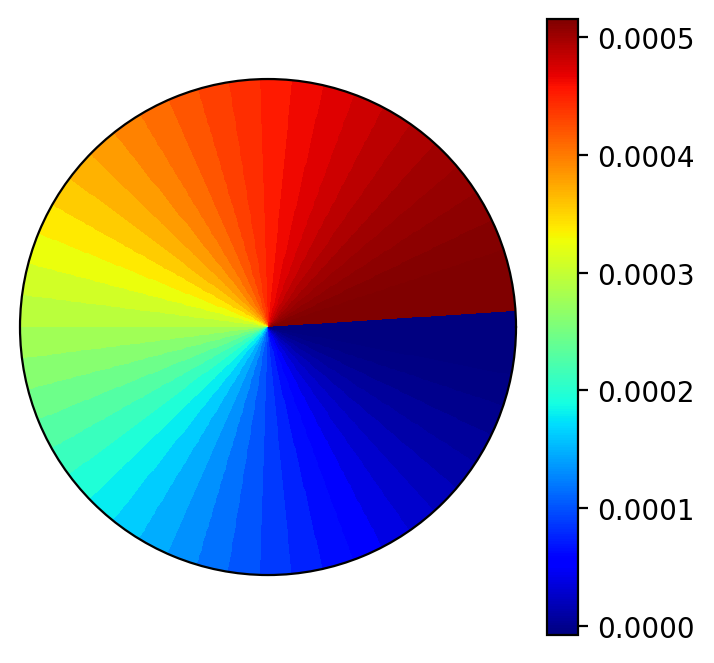

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = Axes3D(fig)
ax.set_title('With masked values')
rad = points
azm = np.linspace(0, 2 * np.pi, len(points))
r, th = np.meshgrid(rad, azm)
z = result_matrix

plt.subplot(projection="polar")

cs = plt.pcolormesh(th, r, z, cmap='jet')

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.grid()
cbar = fig.colorbar(cs)

plt.show()


In [ ]:
import numpy as np

def transform_to_matrix(input_array):
    """
    Функція, що перетворює одновимірний масив в масив розмірності (n, n) з повторюваними значеннями.

    Параметри:
    - input_array: Одновимірний масив розмірності n.

    Повертає:
    - Масив розмірності (n, n) з повторюваними значеннями.
    """
    n = len(input_array)
    reshaped_matrix = np.array([input_array] * n)
    return reshaped_matrix

# Приклад використання
original_array = [1, 2, 3, 4, 5]
result_matrix = transform_to_matrix(original_array)

print("Оригінальний масив:", original_array)
print("Масив розмірності (n, n) з повторюваними значеннями:", result_matrix)


Оригінальний масив: [1, 2, 3, 4, 5]
Масив розмірності (n, n) з повторюваними значеннями: [[1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]]


In [ ]:
import numpy as np

def transform_to_matrix(input_array):
    """
    Функція, що перетворює одновимірний масив в масив розмірності (n, n),
    де на кожній позиції старого масива записано вектор з повторюваним значенням відповідного значення початкового масиву.

    Параметри:
    - input_array: Одновимірний масив розмірності n.

    Повертає:
    - Масив розмірності (n, n) з векторами, де значення векторів повторюються відповідно до значень вхідного масиву.
    """
    n = len(input_array)
    reshaped_matrix = np.array([np.repeat(value, n) for value in input_array])
    return reshaped_matrix

# Приклад використання
original_array = [1, 2, 3, 4, 5]
result_matrix = transform_to_matrix(original_array)

print("Оригінальний масив:", original_array)
print("Масив розмірності (n, n) з векторами та повторюваними значеннями:", result_matrix)


Оригінальний масив: [1, 2, 3, 4, 5]
Масив розмірності (n, n) з векторами та повторюваними значеннями: [[1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]]
